In [1]:
import numpy as np
import pandas as pd
import torch
import copy 
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We create a dataset of harmonic sequences 

In [18]:
length_seq = 50
n_sample = 1000

In [19]:
dataset = []
samplerate = length_seq
for i in range(n_sample):
  fs1 = np.random.randint(samplerate)
  fs2 = np.random.randint(samplerate)
  t = np.linspace(0., 1., samplerate)
  amplitude1 = np.iinfo(np.int16).max/10000
  amplitude2 = np.iinfo(np.int16).max/20000
  data1 = amplitude1 * np.sin(2. * np.pi * fs1 * t)
  data2 = amplitude2 * np.sin(2. * np.pi * fs2 * t)
  dataset.append(data1+data2)

In [20]:
dataset = np.array(dataset)

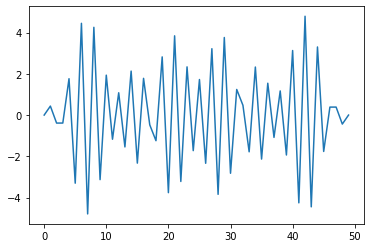

In [21]:
plt.plot(dataset[0])

In [22]:
dataset = pd.DataFrame(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_normalized = pd.DataFrame(scaler.fit_transform(dataset))

In [23]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [24]:
dataset_normalized, seq_len, n_features = create_dataset(dataset_normalized)

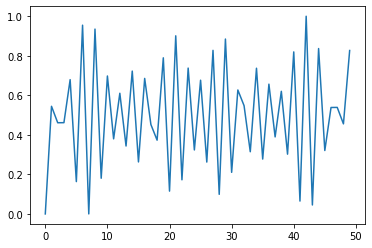

In [25]:
plt.plot(dataset_normalized[0])

In [26]:
n_train = int(n_sample * 0.8)
train_dataset = dataset_normalized[:n_train ]
test_dataset = dataset_normalized[n_train :]

In [27]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [28]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [29]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [33]:
model = RecurrentAutoencoder(seq_len, n_features, 512)
model = model.to(device)

In [34]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [35]:
model, history = train_model(
  model, 
  train_dataset, 
  test_dataset, 
  n_epochs = 50
)

Epoch 1: train loss 11.165861832126975 val loss 10.842571430206299
Epoch 2: train loss 11.009333639740944 val loss 10.850042123794555
Epoch 3: train loss 10.992284752726555 val loss 10.848600912094117
Epoch 4: train loss 10.990178069919347 val loss 10.845839235782623
Epoch 5: train loss 10.987793678492308 val loss 10.887092268466949
Epoch 6: train loss 10.986204684972764 val loss 10.849363160133361
Epoch 7: train loss 10.982028233855964 val loss 10.860565483570099
Epoch 8: train loss 10.97462071120739 val loss 10.853734993934632
Epoch 9: train loss 10.971350047066808 val loss 10.850309355258942
Epoch 10: train loss 10.97407528206706 val loss 10.853526911735536
Epoch 11: train loss 10.970042258128524 val loss 10.850044853687287
Epoch 12: train loss 10.971151213347913 val loss 10.856063177585602
Epoch 13: train loss 10.971676982790232 val loss 10.852688400745391
Epoch 14: train loss 10.966422336921095 val loss 10.851363587379456
Epoch 15: train loss 10.96756484374404 val loss 10.84959521

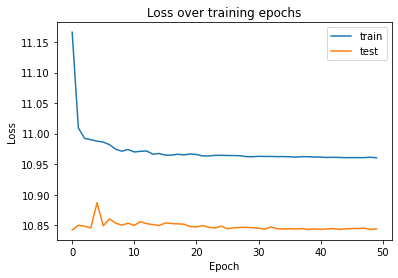

In [36]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = 'LSTM_AE.pth'
torch.save(model, MODEL_PATH)